In [363]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os 
import math

## Analiza podataka

In [364]:
train_data = pd.read_csv('csv/train.csv')

In [365]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [366]:
test_data = pd.read_csv('csv/test.csv')

In [367]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \r\n\r\n The title is fine as i...
2,00013b17ad220c46,""" \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [368]:
train_data.shape, test_data.shape

((159571, 8), (153164, 2))

In [369]:
#train_data[train_data['toxic'] == 1]

Provera da li ima nedostajućih vrednosti:

In [370]:
train_data.isnull().values.any()

False

Nema nedostajućih vrednosti - sve vrednosti su ili 0 ili 1

In [371]:
print(train_data['toxic'].unique()) 
print(train_data['severe_toxic'].unique())
print(train_data['obscene'].unique())
print(train_data['insult'].unique())
print(train_data['threat'].unique())
print(train_data['identity_hate'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


Izdvajanje samo kategorija

In [372]:
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
categories = train_data[classes]

In [373]:
categories.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


Broj komentara po kategorijama

In [374]:
freq_per_class = categories.sum()

In [375]:
freq_per_class

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Grafički prikaz zastupljenosti različitih vrsta komentara

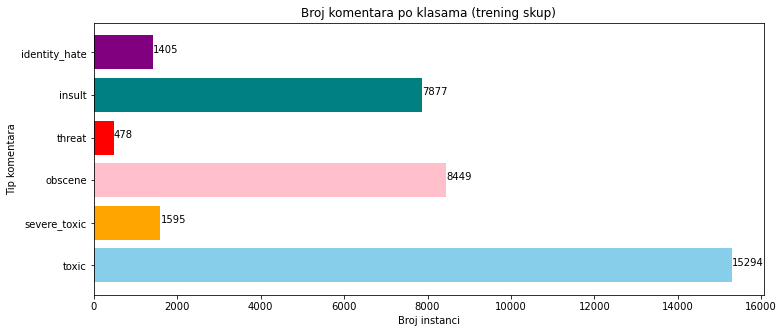

In [376]:
colors = ['skyblue', 'orange', 'pink', 'red', 'teal', 'purple', 'khaki']


plt.figure(figsize=(12,5))
plt.barh(freq_per_class.index, freq_per_class, color = colors)
for index, value in enumerate(freq_per_class):
    plt.text(value, index, str(value))

plt.xlabel('Broj instanci')
plt.ylabel('Tip komentara')
plt.title('Broj komentara po klasama (trening skup)')
plt.savefig('img/01_frequency_bar.png', orientation='landscape')

plt.show()


 ### **TODO: nebalansiranost?**

Broj komentara klasifikovanih u više od jedne klase:

1    6360
2    3480
3    4209
4    1760
5     385
6      31
dtype: int64


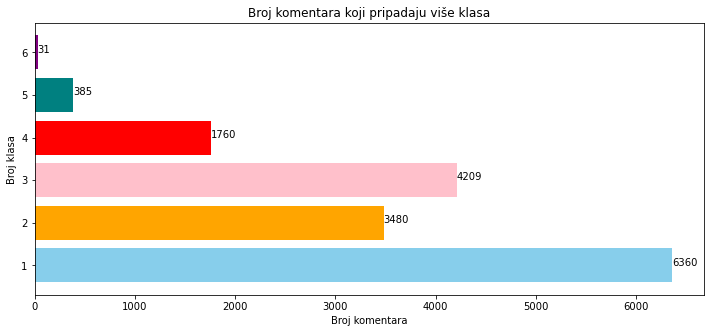

In [377]:

class_sums = train_data.iloc[:, 2:].sum(axis = 1)
counts = class_sums.value_counts().sort_index()
counts = counts.iloc[1:]
print(counts)

plt.figure(figsize=(12,5))
plt.barh(counts.index, counts.values, color = colors)
for index, value in enumerate(counts.values):
    plt.text(value, index+1, str(value))

plt.xlabel('Broj komentara')
plt.ylabel('Broj klasa')
plt.title('Broj komentara koji pripadaju više klasa')
plt.savefig('img/03_multilabel_freq.png', orientation='landscape')

plt.show()



Udeo neklasifikovanih komentara u celom trening skupu:

In [378]:
not_labeled_count= class_sums.value_counts()[0]
print('Broj neoznacenih komentara: ', not_labeled_count)
print('Broj ukupnih komentara: ', train_data.shape[0])
percent_not_labeled = not_labeled_count/train_data.shape[0]
print('Udeo neoznacenih komentara:  {:.2%}'.format(percent_not_labeled))

Broj neoznacenih komentara:  143346
Broj ukupnih komentara:  159571
Udeo neoznacenih komentara:  89.83%



 #### Samo oko 10% trening skupa je klasifikovano u konkretne klase

In [379]:
percents = [round(p/train_data.shape[0]*100, 2) for p in freq_per_class]
percents.append(round(percent_not_labeled*100,2))

legend = freq_per_class.index.values.tolist()
legend.append('not_labeled')

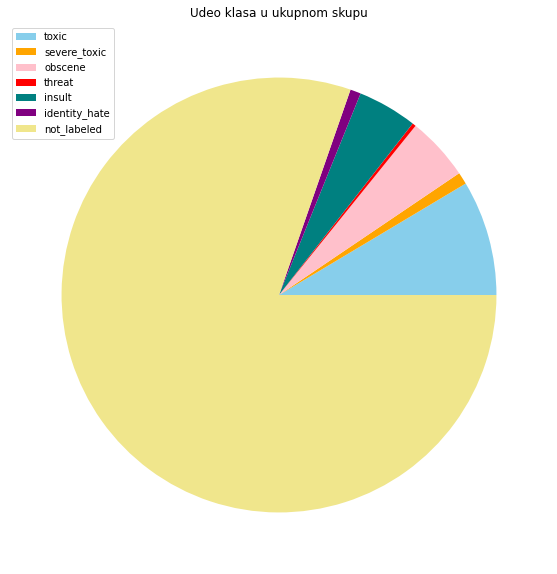

In [380]:

plt.figure(figsize=(10,10))
plt.pie(percents, colors = colors)
plt.legend(legend, loc='upper left')
plt.title('Udeo klasa u ukupnom skupu')
plt.savefig('img/02_class_distribution.png')

plt.show()

## Obrada i priprema teksta

#### TODO: koju metodu primeniti  - n-grami, tf-id, word2vec, glove, byte pair encoding,..?

In [385]:
# Podaci izdvojeni za svaku klasu:

toxic = train_data[train_data.toxic==1]
severe_toxic = train_data[train_data.severe_toxic==1]
obscene = train_data[train_data.obscene==1]
threat = train_data[train_data.threat == 1]
insult = train_data[train_data.insult==1]
identity_hate = train_data[train_data.identity_hate==1]
not_labeled = train_data[train_data[classes].eq(0).all(1)]

### Najčešće reči po klasama

In [386]:
from wordcloud import WordCloud, STOPWORDS

In [387]:
# fja koja vraca string naziva data frame-a

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name


In [388]:
def get_wordcloud(comment_type):
    df = comment_type
    words = ' '.join([text for text in df['comment_text'] ])

    wordcloud = WordCloud(width=2500,
                      height=1600,
                      max_words=500,
                      collocations=False,
                      stopwords=STOPWORDS).generate(words)

    name = get_df_name(df)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(name + ' wordcloud')
    plt.savefig('img/wordclouds/' + name + '.png')
    plt.show()

### Wordcloud za svaku od klasa

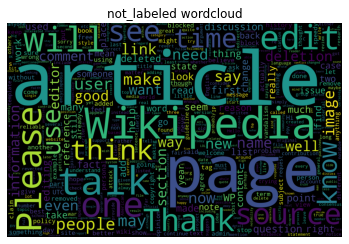

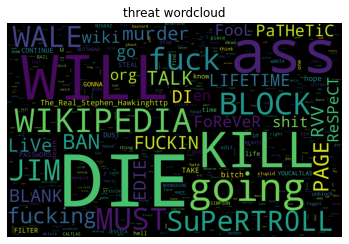

In [389]:
get_wordcloud(not_labeled)
#get_wordcloud(toxic)
#get_wordcloud(severe_toxic)
#get_wordcloud(obscene)
#get_wordcloud(insult)
#get_wordcloud(identity_hate)
get_wordcloud(threat)

### Wordcloud za test skup

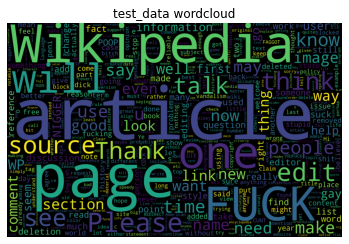

In [390]:
get_wordcloud(test_data)

### Priprema teksta